# Highly Imbalanced Fraud Data 의 분류
## DNN 이용, Class Weight 조정, OverSampling
## ROC 비교

- [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) - Kaggle


- Highly Imbalanced Dataset - dataset는 2013 년 9 월 유럽 카드 소지자 신용 카드 거래로 만들었습니다. 이 dataset는 2 일 동안 발생한 거래를 보여 주며, 284,807 건의 거래 중 492 건의 fraud가 있습니다. 데이터세트는 매우 불균형하며 포지티브 클래스(사기)는 모든 거래의 0.172 %를 차지합니다.


- 이 dataset는 PCA 변환의 결과인 숫자 입력 변수만 포함합니다. 안타깝게도 기밀 유지 문제로 인해 데이터에 대한 원래 feature와 추가 background 정보를 제공할 수 없습니다. 특성 V1, V2, ... V28은 PCA로 얻은 principal component이며 PCA로 변환되지 않은 유일한 기능은 'Time' 과 'Amount' 입니다. '시간' 특성은 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 시간(초) 입니다. 'Amount' 특성은 거래금액 입니다.  'Class'는 사기의 경우 1, 그렇지 않으면 0 입니다.


- 클래스 불균형 비율이 주어지면 Area Under the Precision-Recall Curve (AUPRC)을 사용하여 정확도를 측정하는 것이 좋습니다. 불균형 data 분류에는 confusion matrix 정확도가 의미가 없습니다.

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score, \
                            roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)

### Download the Kaggle Credit Card Fraud data set

- [kaggle creditcard csv file](https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv)

In [2]:
# df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df = pd.read_csv('data/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df[['Time', 'V1', 'V2', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,3.161220e+01,3.384781e+01,25691.160000,1.000000


### 클래스 레이블 불균형 조사

In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
fraud = (df['Class'] == 1).sum()
normal = (df['Class'] == 0).sum()

total = fraud + normal

print(f"Total = {total:,}")
print(f"Fraud = {fraud/total*100:,.2f}%")
print(f"Normal = {normal/total*100:,.2f}%")

Total = 284,807
Fraud = 0.17%
Normal = 99.83%


### Clean, split and normalize the data

In [6]:
cleaned_df = df.copy()

# Time 을 일중 시간으로 변환
cleaned_df.loc[:, "Time"] = cleaned_df.loc[:, "Time"].apply(lambda x : x / 3600 % 24) 

# Amount column 은 편차가 크므로 log-scale 로 변환
eps=0.001      # 0 => 0.1¢
cleaned_df['Amount'] = np.log(cleaned_df.pop('Amount') + eps)

cleaned_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


In [7]:
cleaned_df['Amount'].describe()

count    284807.000000
mean          2.942089
std           2.023685
min          -6.907755
25%           1.722945
50%           3.091088
75%           4.345959
max          10.153902
Name: Amount, dtype: float64

In [8]:
labels = np.array(cleaned_df.pop('Class'))
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [9]:
X = cleaned_df.values
X.shape

(284807, 30)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, 
                                        test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227845, 30), (56962, 30), (227845,), (56962,))

In [11]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

### metrics 정의

- Accuracy 로 예측하면 항상 99.8%+ 정확성을 달성하므로, 다양한 metrics 활용하여 측정

In [12]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

## Simple NN model 정의 - 이진 분류 모델

In [13]:
def make_model(metrics = METRICS):
    
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(32, activation='relu', 
                            input_shape=(X_train.shape[-1],)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid'),
  ])

    model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss = 'binary_crossentropy',
      metrics=metrics)

    return model

## Baseline model build

In [14]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10, # no of epochs of no improvement          
    mode='max',  #val_auc 가 10 번 연속 증가 안하면 stop           
    restore_best_weights=True)  # epoch 의 best weight 저장

In [15]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [16]:
model = make_model()
baseline_history = model.fit(X_train, y_train, batch_size=BATCH_SIZE,
                             epochs=EPOCHS, 
                        callbacks=[early_stopping], 
                             validation_data=(X_test, y_test))

Epoch 1/100
112/112 [==============================] - 5s 30ms/step - loss: 0.4482 - tp: 24.1858 - fp: 15144.7522 - tn: 101335.6283 - fn: 186.2124 - accuracy: 0.7982 - precision: 0.0016 - recall: 0.1641 - auc: 0.2942 - val_loss: 0.0400 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 56861.0000 - val_fn: 101.0000 - val_accuracy: 0.9982 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2461
Epoch 2/100
112/112 [==============================] - 1s 7ms/step - loss: 0.0441 - tp: 2.2478 - fp: 9.3540 - tn: 116487.8142 - fn: 191.3628 - accuracy: 0.9983 - precision: 0.1678 - recall: 0.0111 - auc: 0.4802 - val_loss: 0.0104 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 56861.0000 - val_fn: 101.0000 - val_accuracy: 0.9982 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8685
Epoch 3/100
112/112 [==============================] - 1s 7ms/step - loss: 0.0177 - tp: 9.3451 - fp: 5.6903 - tn: 116495.7080 - fn: 180.0354 - accuracy: 0.9985 - precision: 0.5506 - 

Epoch 42/100
112/112 [==============================] - 1s 7ms/step - loss: 0.0025 - tp: 160.2743 - fp: 21.9823 - tn: 116464.2655 - fn: 44.2566 - accuracy: 0.9995 - precision: 0.8889 - recall: 0.7852 - auc: 0.9633 - val_loss: 0.0032 - val_tp: 80.0000 - val_fp: 13.0000 - val_tn: 56848.0000 - val_fn: 21.0000 - val_accuracy: 0.9994 - val_precision: 0.8602 - val_recall: 0.7921 - val_auc: 0.9354
Epoch 43/100
112/112 [==============================] - 1s 7ms/step - loss: 0.0027 - tp: 155.4159 - fp: 22.0619 - tn: 116464.6460 - fn: 48.6549 - accuracy: 0.9994 - precision: 0.8684 - recall: 0.7635 - auc: 0.9614 - val_loss: 0.0031 - val_tp: 81.0000 - val_fp: 14.0000 - val_tn: 56847.0000 - val_fn: 20.0000 - val_accuracy: 0.9994 - val_precision: 0.8526 - val_recall: 0.8020 - val_auc: 0.9404
Epoch 44/100
112/112 [==============================] - 1s 7ms/step - loss: 0.0022 - tp: 166.5664 - fp: 21.5929 - tn: 116467.2743 - fn: 35.3451 - accuracy: 0.9995 - precision: 0.8792 - recall: 0.8486 - auc: 0.976

In [17]:
baseline_history.history['val_accuracy'][-1]

0.9994557499885559

## Plot trainig history

In [18]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    
    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(metrics):
        name = metric.capitalize()
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history['val_' + metric], label='Val')
        plt.title(metric)
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()
    plt.tight_layout()

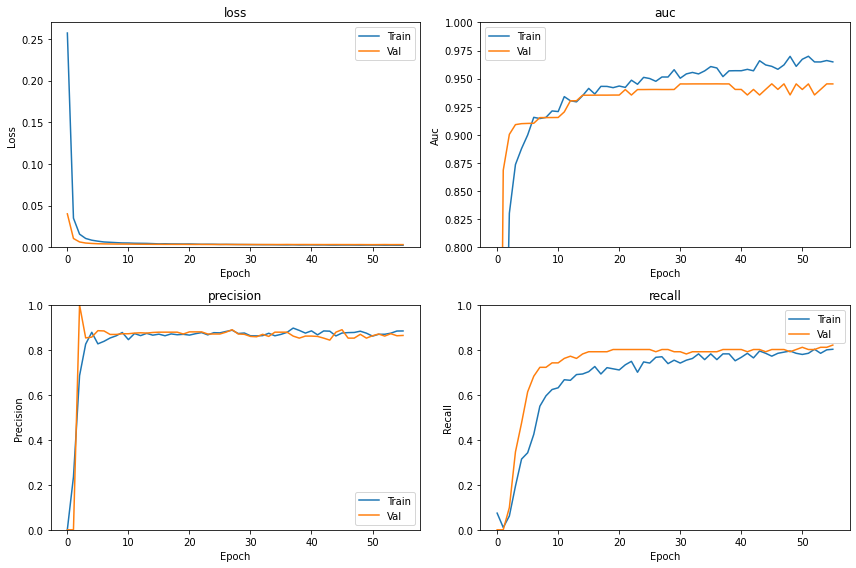

In [19]:
plot_metrics(baseline_history)

## Evaluate Metric

- confusion matrix 를 이용하여 metrics 요약

In [20]:
predictions_baseline  = model.predict(X_test, batch_size=BATCH_SIZE)

predictions_baseline.shape

(56962, 1)

In [21]:
def plot_cm(labels, pred_proba, threshold=0.5):
    
    y_predict = pred_proba > threshold
    
    cm = confusion_matrix(y_test, y_predict)
    
    print("confution matrix\n", cm)
    print()
    print("f1 score\n", f1_score(y_test, y_predict))
    print()
    print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_predict)))
    print("Precision: {:.5f}".format(precision_score(y_test, y_predict)))
    print("Recall: {:.5f}".format(recall_score(y_test, y_predict)))
    
    plt.figure(figsize=(5,5))

    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @>{:.2f} '.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

### Test dataset 으로 evaluate 하고, confusion matrix 를 그린다

confution matrix
 [[56851    10]
 [   20    81]]

f1 score
 0.84375

Accuracy: 0.99947
Precision: 0.89011
Recall: 0.80198


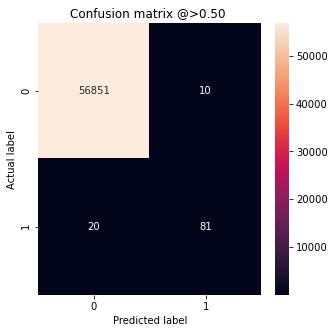

In [22]:
plot_cm(y_test, predictions_baseline, threshold=0.5)

## Plot ROC

In [23]:
def plot_roc(name, labels, predictions, **kwargs):
    
    fp, tp, _ = roc_curve(labels, predictions)
    auc = roc_auc_score(y_test, predictions)
    
    plt.plot(100*fp, 100*tp, label=f"auc of {name}={auc:.5f}", linewidth=2, **kwargs)
    plt.xlabel('FP [%]')
    plt.ylabel('TP [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    fig = plt.gcf()
    fig.set_size_inches(8, 6)

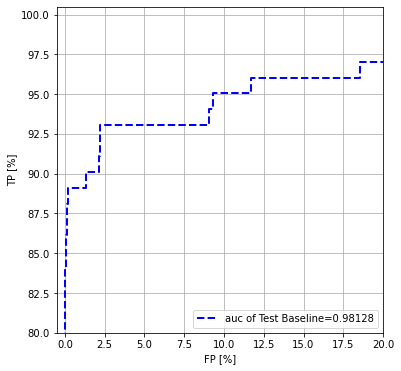

In [24]:
plot_roc("Test Baseline", y_test, predictions_baseline, color='blue', linestyle='--')
plt.legend(loc='lower right')

정밀도가 비교적 높은 것처럼 보이지만 리콜 및 ROC 곡선 아래 면적 (AUC)은 원하는만큼 높지 않습니다. 분류기는 종종 정밀도와 재현율을 모두 극대화하려고 할 때 어려움에 직면합니다. 특히 불균형 데이터 세트로 작업 할 때는 더욱 그렇습니다. 

## Class Weight 조정

사용할 positive 샘플이 많지 않기 때문에 가용한 적은 수의 sample 에 classifier 가 더 비중을 두도록 할 수 있다. 

step1 - 레이블 및 관련 가중치로 dictionary 정의 
```
class_weight = {0: 1.,
                        1: 50.,
                        2: 2.}
```                
step2 - dictionary를 매개 변수로 공급:  
```
    model.fit(X_train, Y_train, nb_epoch=5, batch_size=32, class_weight=class_weight)
```

- class 1 하나를 50 개의 classs 0 로 취급 $\rightarrow$ loss function 계산 시 class_weight 에 지정된 대로 가중 평균

In [25]:
normal, fraud, total

(284315, 492, 284807)

In [26]:
# total/2 로 scale 하면 loss를 비슷한 크기로 유지하는 데 도움이됩니다.
# 모든 example의 가중치 합계는 동일하게 유지됩니다.

weight_for_0 = (1 / normal)*(total) / 2.0 
weight_for_1 = (1 / fraud)*(total) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


class_weight  

    학습 클래스의 샘플에 대한 모델 손실에 적용할 가중치에 대한 사전 매핑 클래스 인덱스(정수). 이는 모델이 과소 표현된 클래스의 샘플에 "더 많은주의를 기울이도록"지시하는 데 유용.

In [27]:
weighted_model = make_model()

weighted_history = weighted_model.fit(X_train, y_train, 
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS, 
                                    callbacks = [early_stopping], 
                                    validation_data=(X_test, y_test),
                                    class_weight=class_weight) 

Epoch 1/100
112/112 [==============================] - 4s 15ms/step - loss: 0.5460 - tp: 268.3628 - fp: 62599.9735 - tn: 110748.5221 - fn: 35.9204 - accuracy: 0.6544 - precision: 0.0052 - recall: 0.8732 - auc: 0.8970 - val_loss: 0.4258 - val_tp: 90.0000 - val_fp: 1570.0000 - val_tn: 55291.0000 - val_fn: 11.0000 - val_accuracy: 0.9722 - val_precision: 0.0542 - val_recall: 0.8911 - val_auc: 0.9486
Epoch 2/100
112/112 [==============================] - 1s 7ms/step - loss: 0.3614 - tp: 172.2212 - fp: 6855.6637 - tn: 109633.2478 - fn: 29.6460 - accuracy: 0.9353 - precision: 0.0227 - recall: 0.8294 - auc: 0.9183 - val_loss: 0.1955 - val_tp: 89.0000 - val_fp: 616.0000 - val_tn: 56245.0000 - val_fn: 12.0000 - val_accuracy: 0.9890 - val_precision: 0.1262 - val_recall: 0.8812 - val_auc: 0.9615
Epoch 3/100
112/112 [==============================] - 1s 7ms/step - loss: 0.2024 - tp: 165.6106 - fp: 2680.1770 - tn: 113821.7434 - fn: 23.2478 - accuracy: 0.9774 - precision: 0.0588 - recall: 0.8877 - au

Epoch 22/100
112/112 [==============================] - 1s 7ms/step - loss: 0.1081 - tp: 194.4071 - fp: 3265.0531 - tn: 113218.9646 - fn: 12.3540 - accuracy: 0.9721 - precision: 0.0564 - recall: 0.9392 - auc: 0.9924 - val_loss: 0.0613 - val_tp: 92.0000 - val_fp: 1018.0000 - val_tn: 55843.0000 - val_fn: 9.0000 - val_accuracy: 0.9820 - val_precision: 0.0829 - val_recall: 0.9109 - val_auc: 0.9884
Epoch 23/100
112/112 [==============================] - 1s 7ms/step - loss: 0.1067 - tp: 182.4602 - fp: 2977.1593 - tn: 113516.7080 - fn: 14.4513 - accuracy: 0.9745 - precision: 0.0541 - recall: 0.9166 - auc: 0.9929 - val_loss: 0.0582 - val_tp: 91.0000 - val_fp: 942.0000 - val_tn: 55919.0000 - val_fn: 10.0000 - val_accuracy: 0.9833 - val_precision: 0.0881 - val_recall: 0.9010 - val_auc: 0.9898
Epoch 24/100
112/112 [==============================] - 1s 8ms/step - loss: 0.0928 - tp: 186.2478 - fp: 2960.8584 - tn: 113530.3982 - fn: 13.2743 - accuracy: 0.9752 - precision: 0.0603 - recall: 0.9334 - au

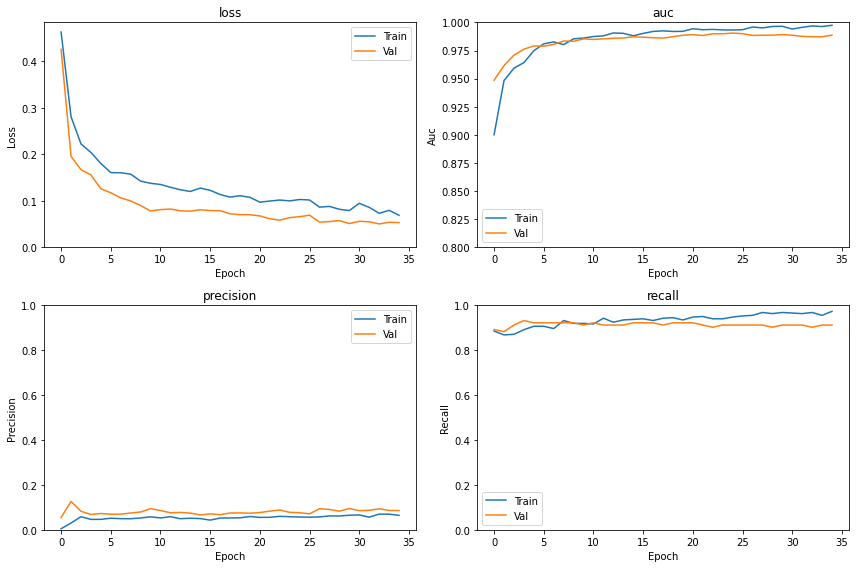

In [28]:
plot_metrics(weighted_history)

In [29]:
predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.06570450216531754
tp :  92.0
fp :  1119.0
tn :  55742.0
fn :  9.0
accuracy :  0.9801973104476929
precision :  0.07597026973962784
recall :  0.9108911156654358
auc :  0.9905160665512085

confution matrix
 [[55742  1119]
 [    9    92]]

f1 score
 0.14024390243902438

Accuracy: 0.98020
Precision: 0.07597
Recall: 0.91089


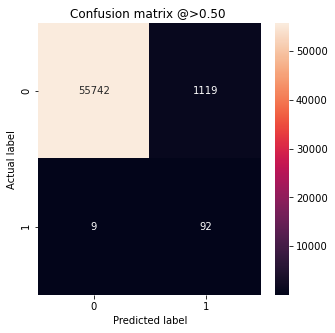

In [30]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
    
print()

plot_cm(y_test, predictions_weighted, threshold=0.5)

## Plot the ROC

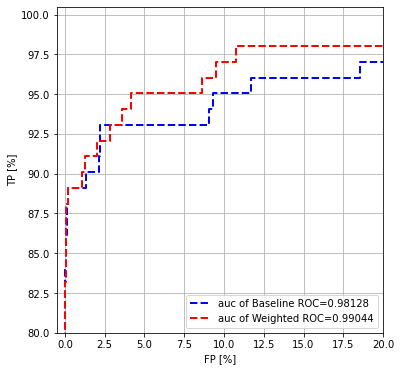

In [31]:
plot_roc("Baseline ROC", y_test, predictions_baseline, color='blue', linestyle='--')

plot_roc("Weighted ROC", y_test, predictions_weighted, color='red', linestyle='--')

plt.legend(loc='lower right')